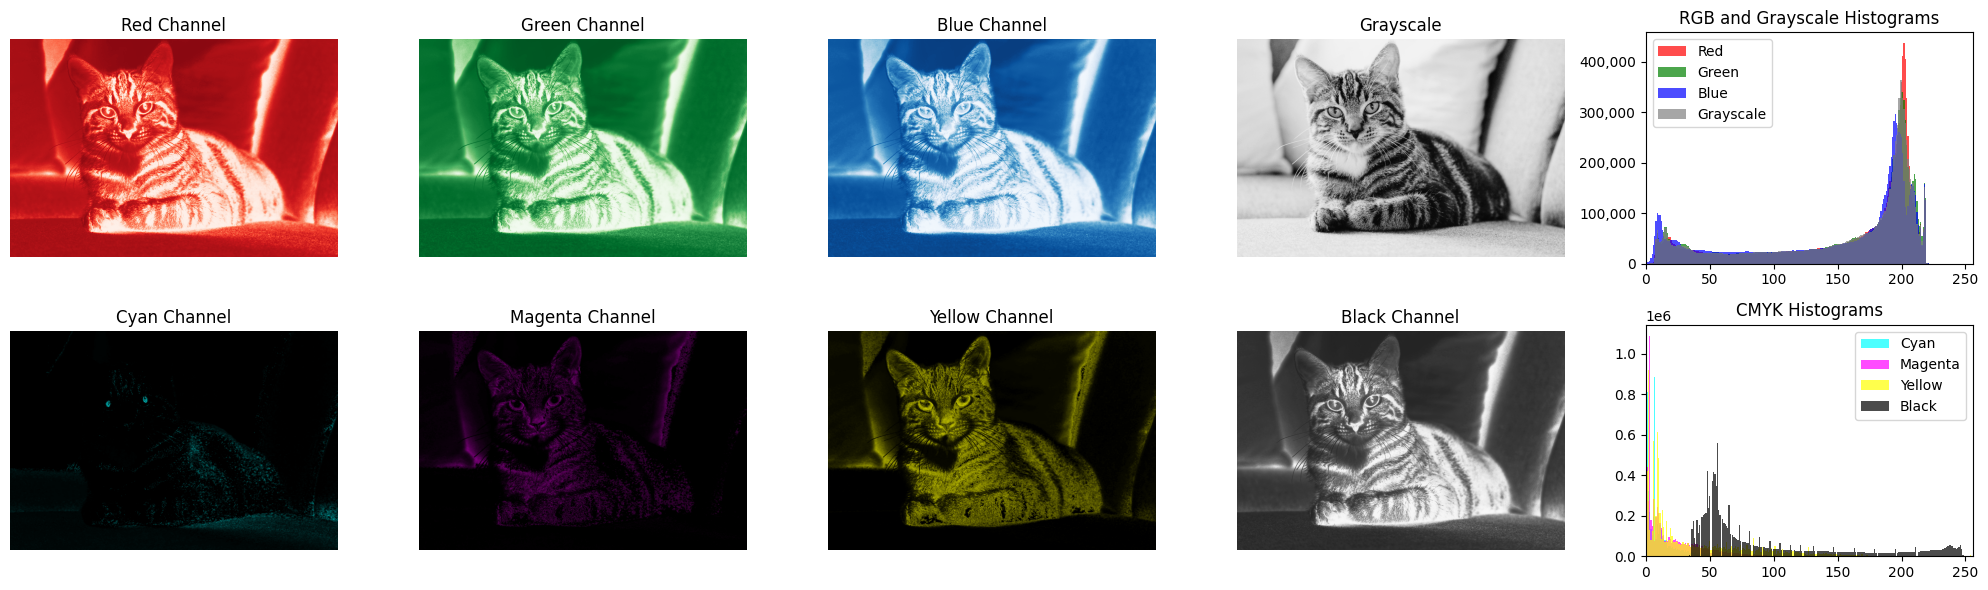

In [1]:
import cv2, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# RGB 이미지를 CMYK로 변환하는 함수
def rgb_to_cmyk(image):
    image = image / 255.0  # 이미지 정규화 (0~1 범위로 변환)
    R, G, B = cv2.split(image)  # RGB 채널 분리
    K = 1 - np.max(image, axis=2)  # Key (Black) 채널 계산
    K[K == 1] = 0.99  # K가 1일 경우 0.99로 설정하여 나누기 0 오류 방지
    C = (1 - R - K) / (1 - K + 1e-8)  # Cyan 채널 계산
    M = (1 - G - K) / (1 - K + 1e-8)  # Magenta 채널 계산
    Y = (1 - B - K) / (1 - K + 1e-8)  # Yellow 채널 계산
    CMYK = cv2.merge((C, M, Y, K))  # CMYK 채널 합치기
    return CMYK

# 각 CMYK 채널에 검정 배경을 적용하는 함수
def apply_black_background(channel, color):
    h, w = channel.shape  # 채널의 높이와 너비
    background = np.zeros((h, w, 3), dtype=np.uint8)  # 검정 배경 생성
    if color == 'cyan':
        background[:, :, 1] = channel  # Cyan 채널 배경에 채우기
        background[:, :, 2] = channel  # Cyan 채널 배경에 채우기
    elif color == 'magenta':
        background[:, :, 0] = channel  # Magenta 채널 배경에 채우기
        background[:, :, 2] = channel  # Magenta 채널 배경에 채우기
    elif color == 'yellow':
        background[:, :, 0] = channel  # Yellow 채널 배경에 채우기
        background[:, :, 1] = channel  # Yellow 채널 배경에 채우기
    elif color == 'black':
        background[:, :, 0] = channel  # Black 채널 배경에 채우기
        background[:, :, 1] = channel  # Black 채널 배경에 채우기
        background[:, :, 2] = channel  # Black 채널 배경에 채우기
    return background

# 이미지 파일 읽기
image = cv2.imread('example.jpg')
if image is None:
    raise FileNotFoundError("The file 'example.jpg' was not found!")  # 이미지 파일이 없을 경우 오류 발생

# BGR에서 RGB로 변환
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# RGB 채널 분리
R, G, B = cv2.split(image_rgb)

# 그레이스케일 변환
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# CMYK로 변환
cmyk_image = rgb_to_cmyk(image_rgb)
C, M, Y, K = cv2.split(cmyk_image)  # 각 CMYK 채널 분리

# CMYK 채널을 8비트 값으로 스케일링
C = (C * 255).astype(np.uint8)
M = (M * 255).astype(np.uint8)
Y = (Y * 255).astype(np.uint8)
K = (K * 255).astype(np.uint8)

# CMYK 채널에 검정 배경 적용
cyan_background = apply_black_background(C, 'cyan')
magenta_background = apply_black_background(M, 'magenta')
yellow_background = apply_black_background(Y, 'yellow')
black_background = apply_black_background(K, 'black')

# 히스토그램을 계산할 때 0이 아닌 값만 사용
C_non_zero = C[C != 0]
M_non_zero = M[M != 0]
Y_non_zero = Y[Y != 0]
K_non_zero = K[K != 0]

# 그래프 설정
cols, rows = 5, 2  # 그래프의 행과 열 설정
chart_idx = 0  # 그래프 인덱스 초기화

# 히스토그램의 막대 너비 설정
bin_width = 1  # 히스토그램 막대 너비 (1로 설정)
bin_range = 256  # 히스토그램 범위 (0~255)

# 그래프 설정
plt.figure(figsize=(4*cols, 3*rows))  # 동적으로 그림 크기 설정

# 첫 번째 행: RGB 채널과 그레이스케일 이미지
plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(R, cmap='Reds')  # 빨간 채널 표시
plt.title('Red Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(G, cmap='Greens')  # 초록 채널 표시
plt.title('Green Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(B, cmap='Blues')  # 파랑 채널 표시
plt.title('Blue Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(gray, cmap='gray')  # 그레이스케일 이미지 표시
plt.title('Grayscale')
plt.axis('off')

# RGB 히스토그램을 하나의 그래프에 표시 (X값이 겹치지 않도록 오프셋 추가)
plt.subplot(rows, cols, chart_idx := chart_idx + 1)
# 각 채널의 히스토그램 계산
r_hist, r_bins = np.histogram(R.ravel(), bins=bin_range, range=(0, 256))
g_hist, g_bins = np.histogram(G.ravel(), bins=bin_range, range=(0, 256))
b_hist, b_bins = np.histogram(B.ravel(), bins=bin_range, range=(0, 256))
gray_hist, gray_bins = np.histogram(gray.ravel(), bins=bin_range, range=(0, 256))
# 히스토그램을 시프트하여 겹치지 않게 표시
plt.bar(r_bins[:-1] , r_hist, width=bin_width, color='r', alpha=0.7, label='Red')
plt.bar(g_bins[:-1] , g_hist, width=bin_width, color='g', alpha=0.7, label='Green')
plt.bar(b_bins[:-1] , b_hist, width=bin_width, color='b', alpha=0.7, label='Blue')
plt.bar(gray_bins[:-1] , gray_hist, width=bin_width, color='gray', alpha=0.7, label='Grayscale')
plt.title('RGB and Grayscale Histograms')
plt.xlim([0, 256])
# y축의 값 형식을 천 단위 구분기호로 표시
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{int(value):,}'))
plt.legend()

# 두 번째 행: CMYK 채널
plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(cyan_background)  # Cyan 채널 배경에 채운 이미지 표시
plt.title('Cyan Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(magenta_background)  # Magenta 채널 배경에 채운 이미지 표시
plt.title('Magenta Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(yellow_background)  # Yellow 채널 배경에 채운 이미지 표시
plt.title('Yellow Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(black_background)  # Black 채널 배경에 채운 이미지 표시
plt.title('Black Channel')
plt.axis('off')

# CMYK 히스토그램을 하나의 그래프에 표시 (X값이 겹치지 않도록 오프셋 추가)
plt.subplot(rows, cols, chart_idx := chart_idx + 1)
# 각 CMYK 채널의 히스토그램 계산
c_hist, c_bins = np.histogram(C_non_zero.ravel(), bins=bin_range, range=(0, 256))
m_hist, m_bins = np.histogram(M_non_zero.ravel(), bins=bin_range, range=(0, 256))
y_hist, y_bins = np.histogram(Y_non_zero.ravel(), bins=bin_range, range=(0, 256))
k_hist, k_bins = np.histogram(K_non_zero.ravel(), bins=bin_range, range=(0, 256))
# 히스토그램을 시프트하여 겹치지 않게 표시
plt.bar(c_bins[:-1] , c_hist, width=bin_width, color='cyan', alpha=0.7, label='Cyan')
plt.bar(m_bins[:-1] , m_hist, width=bin_width, color='magenta', alpha=0.7, label='Magenta')
plt.bar(y_bins[:-1] , y_hist, width=bin_width, color='yellow', alpha=0.7, label='Yellow')
plt.bar(k_bins[:-1] , k_hist, width=bin_width, color='black', alpha=0.7, label='Black')
plt.title('CMYK Histograms')
plt.xlim([0, 256])
plt.legend()

plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 표시